# TFI Kicked Ising Model Analysis

- **Model**: Transverse Field Ising (TFI) Trotter circuits on IBM Eagle topology (127 qubits)
- **Methods**: Pauli propagation with truncation and Monte Carlo sampling
- **Validation**: Comparison with IBM Eagle experimental data and tensor network simulations
- **Analysis**: Runtime scaling, MSE convergence, and expectation values across circuit depths


In [1]:
# Standard library imports
import json
import logging
import os
import time
from pathlib import Path

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np

from qiskit.quantum_info import Pauli


# Custom package imports
from pauli_propagation import PauliTerm, PauliPropagator, staircasetopology2d_qc
from pauli_propagation.circuit_topologies import tfi_trotter_circuit
from pauli_propagation.decomposition import su4_kak_reconstruct, su4_kak_decomp
from pauli_propagation.gates import QuantumGate
from pauli_propagation.monte_carlo import MonteCarlo
from pauli_propagation.utils import encode_pauli

# Configure logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
# plt.rcParams['figure.dpi'] = 200
plt.style.use('default')

In [2]:
nq = 127  # IBM Eagle has 127 qubits
nl = 5    # 5 layers

qc_tfi = tfi_trotter_circuit(nq, nl)

pauli_label = "I" * 64 + "Z" + "I" * 62  # 62 I's + 1 Z + 64 I's = 127 total
key = encode_pauli(Pauli(pauli_label))
init_term = PauliTerm(1.0, key, nq)

product_label = "0" * nq

prop_tfi = PauliPropagator(qc_tfi)

max_weight = 4

layers_tfi = prop_tfi.propagate(init_term, 
                                max_weight=max_weight, 
                                history = False,
                                use_parallel=False)

exp_tfi = prop_tfi.expectation_pauli_sum(layers_tfi, product_label)

print(exp_tfi)

Propagating, max weight: 4:   0%|          | 0/1355 [00:00<?, ?it/s]

0.0


In [3]:
# Propagate TFI Trotter circuits for several depths L and
# truncation thresholds k, recording run-time & expectation values
# into JSON files under results/tfi/.

k_vals = [1,2,3,4,5,6,7,8]          # truncation thresholds
L_vals = [6]  # circuit repetitions (depth)
nq = 127                              # number of qubits (IBM Eagle)

out_dir_tfi = Path("results") / "tfi"
out_dir_tfi.mkdir(parents=True, exist_ok=True)

for L in L_vals:
    # build the TFI Trotter circuit
    qc_tfi = tfi_trotter_circuit(nqubits=nq,
                                 nlayers=L,
                                 start_with_ZZ=True)


    # initial Pauli term (single-Z on qubit-62, 0 indexed )
    pauli_label = "I" * 64 + "Z" + "I" * 62
    key = encode_pauli(Pauli(pauli_label))
    init_term = PauliTerm(1.0, key, nq)

    prop_tfi = PauliPropagator(qc_tfi)

    # open / create JSON file for this depth
    output_path = out_dir_tfi / f"default_prop_results_L{L}.json"
    if output_path.exists():
        with open(output_path, "r") as f:
            prop_results_dict = json.load(f)
    else:
        prop_results_dict = {"prop_time": {}, "exp_time": {}, "expectation": {}}

    # iterate over truncation thresholds
    for k in k_vals:
        k_str = str(k)
        if k_str in prop_results_dict["prop_time"]:
            print(f"L={L} with k={k} already exists, skipping")
            continue

        # propagate 
        t0 = time.time()
        layers_trunc = prop_tfi.propagate(init_term,
                                          max_weight=k,
                                          history=False,
                                          use_parallel=True)
        t_prop = time.time() - t0

        # expectation value 
        t1 = time.time()
        est_exp = prop_tfi.expectation_pauli_sum(layers_trunc, "0" * nq)
        t_exp = time.time() - t1

        # record results
        prop_results_dict["prop_time"][k_str] = [t_prop]
        prop_results_dict["exp_time"][k_str] = [t_exp]
        prop_results_dict["expectation"][k_str] = [est_exp]

        print(f"L={L}, k={k} done: prop={t_prop:.2f}s, exp={t_exp:.2f}s")

    # save / update JSON file
    with open(output_path, "w") as f:
        json.dump(prop_results_dict, f, indent=2)
    print(f"Results for L={L} saved to {output_path}")

L=6 with k=1 already exists, skipping
L=6 with k=2 already exists, skipping
L=6 with k=3 already exists, skipping
L=6 with k=4 already exists, skipping
L=6 with k=5 already exists, skipping
L=6 with k=6 already exists, skipping
L=6 with k=7 already exists, skipping
L=6 with k=8 already exists, skipping
Results for L=6 saved to results\tfi\default_prop_results_L6.json


<!-- # Load expectation data from JSON files for different circuit depths L
results_dir = Path("results") / "tfi"
L_vals = [4]  # depths from 1 to 10
k_vals = [1, 2, 3, 4, 5,6,7,8,9,10]      # truncation thresholds

# Initialize a dictionary to store expectation values
expectation_data = {}

for L in L_vals:
    file_path = results_dir / f"default_prop_results_L{L}.json"
    with open(file_path, "r") as f:
        data = json.load(f)
    # Extract the first recorded expectation value for each k
    expectations = [data["expectation"][str(k)][0] for k in k_vals]
    expectation_data[L] = expectations

# Plotting
plt.figure(figsize=(8, 6))
for L, exps in expectation_data.items():
    plt.plot(k_vals, exps, marker='o', label=f"L={L}")

plt.xlabel("Truncation weight k")
plt.ylabel("Expectation value")
plt.title("Expectation vs Truncation Weight for Various Depths L")
plt.legend(title="Circuit Depth L")
plt.grid(True)
plt.tight_layout()
plt.show() -->

<!-- import json
from pathlib import Path
import matplotlib.pyplot as plt

# Directory containing the JSON results
results_dir = Path("results") / "tfi"

# Truncation thresholds (assuming k starts from 1)
k_vals = [1, 2, 3, 4, 5, 6, 7, 8]
# Circuit depths to include
L_vals = [4,6]

# Load expectation values for each L and k
expectation_data = {}
for L in L_vals:
    file_path = results_dir / f"default_prop_results_L{L}.json"
    if not file_path.exists():
        continue
    with open(file_path, "r") as f:
        data = json.load(f)
    # collect f^{(k)} for k=0..max, define f^{(0)}=0 for convenience
    f_vals = {0: 0.0}
    for k in k_vals:
        f_vals[k] = data["expectation"].get(str(k), [None])[0]
    expectation_data[L] = f_vals

# Compute and plot differences Δ_k(L) = |f^{(k)}(L) - f^{(k-1)}(L)|
plt.figure(figsize=(8, 6))
for L, f_vals in expectation_data.items():
    delta_vals = []
    ks = []
    for k in k_vals:
        prev = f_vals.get(k-1)
        curr = f_vals.get(k)
        if prev is None or curr is None:
            continue
        delta = abs(curr - prev)
        ks.append(k)
        delta_vals.append(delta)
    plt.plot(ks, delta_vals, marker='o', label=f"L={L}")

plt.xlabel("Truncation weight k")
plt.yscale("log", base=10)
plt.title("Log-scale Difference of Expectation vs Truncation Weight")
plt.legend(title="Circuit Depth L")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show() -->


In [4]:
# Propagate TFI Trotter circuits for several depths L and
# truncation thresholds k, recording run-time & expectation values
# into JSON files under results/tfi/.

k_vals = [1,2,3,4,5,6,7]          # truncation thresholds
ibm_L  = 20 # circuit repetitions (depth)
theta_hs = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8, 1., 1.5707]
nq = 127                              # number of qubits (IBM Eagle)

out_dir_tfi = Path("results") / "tfi"
out_dir_tfi.mkdir(parents=True, exist_ok=True)

for theta_h in theta_hs:
    # build the TFI Trotter circuit
    qc_tfi = tfi_trotter_circuit(nqubits=nq,
                             nlayers=ibm_L,           
                             start_with_ZZ=False,     # RX first
                             rx_theta=theta_h,        
                             rzz_theta=-np.pi/2)     

    # initial Pauli term (single-Z on qubit-62, 0 indexed )
    pauli_label = "I" * 64 + "Z" + "I" * 62
    key = encode_pauli(Pauli(pauli_label))
    init_term = PauliTerm(1.0, key, nq)

    prop_tfi = PauliPropagator(qc_tfi)

    # open / create JSON file for this depth
    output_path = out_dir_tfi / f"ibm_prop_results_theta_h_{theta_h}.json"
    if output_path.exists():
        with open(output_path, "r") as f:
            prop_results_dict = json.load(f)
    else:
        prop_results_dict = {"prop_time": {}, "exp_time": {}, "expectation": {}}

    # iterate over truncation thresholds
    for k in k_vals:
        k_str = str(k)
        if k_str in prop_results_dict["prop_time"]:
            print(f"L={L} with k={k} already exists, skipping")
            continue

        # propagate 
        t0 = time.time()
        layers_trunc = prop_tfi.propagate(init_term,
                                          max_weight=k,
                                          history=False,
                                          use_parallel=False)
        t_prop = time.time() - t0

        # expectation value 
        t1 = time.time()
        est_exp = prop_tfi.expectation_pauli_sum(layers_trunc, "0" * nq)
        t_exp = time.time() - t1

        # record results
        prop_results_dict["prop_time"][k_str] = [t_prop]
        prop_results_dict["exp_time"][k_str] = [t_exp]
        prop_results_dict["expectation"][k_str] = [est_exp]

        print(f"L={L}, k={k} done: prop={t_prop:.2f}s, exp={t_exp:.2f}s")

    # save / update JSON file
    with open(output_path, "w") as f:
        json.dump(prop_results_dict, f, indent=2)
    print(f"Results for theta_h={theta_h} saved to {output_path}")

L=6 with k=1 already exists, skipping
L=6 with k=2 already exists, skipping
L=6 with k=3 already exists, skipping
L=6 with k=4 already exists, skipping
L=6 with k=5 already exists, skipping
L=6 with k=6 already exists, skipping
L=6 with k=7 already exists, skipping
Results for theta_h=0.0 saved to results\tfi\ibm_prop_results_theta_h_0.0.json
L=6 with k=1 already exists, skipping
L=6 with k=2 already exists, skipping
L=6 with k=3 already exists, skipping
L=6 with k=4 already exists, skipping
L=6 with k=5 already exists, skipping
L=6 with k=6 already exists, skipping
L=6 with k=7 already exists, skipping
Results for theta_h=0.1 saved to results\tfi\ibm_prop_results_theta_h_0.1.json
L=6 with k=1 already exists, skipping
L=6 with k=2 already exists, skipping
L=6 with k=3 already exists, skipping
L=6 with k=4 already exists, skipping
L=6 with k=5 already exists, skipping
L=6 with k=6 already exists, skipping
L=6 with k=7 already exists, skipping
Results for theta_h=0.2 saved to results\tfi

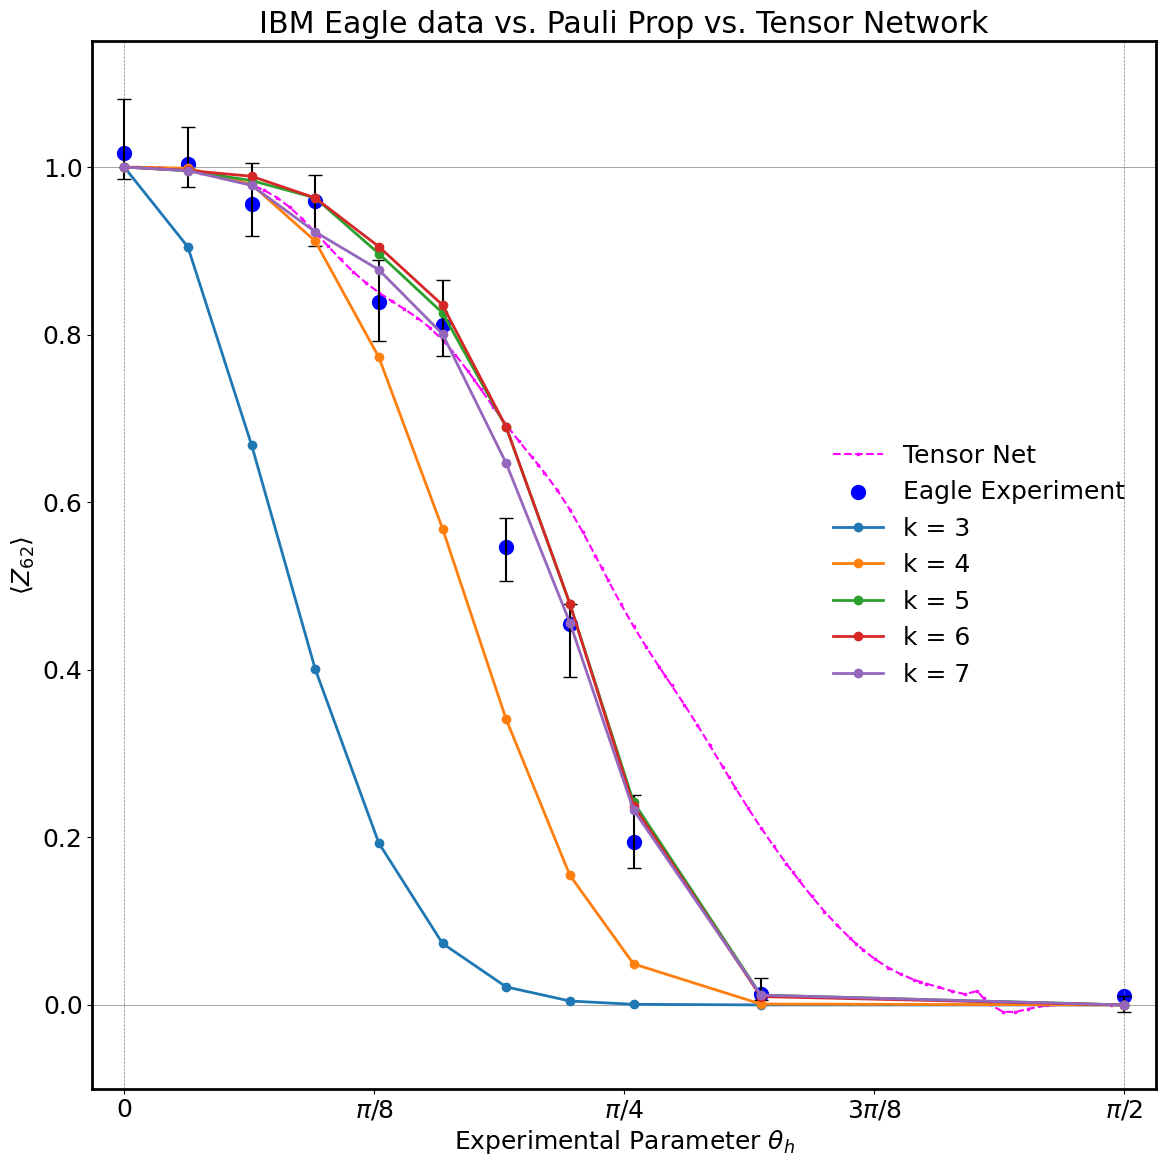

In [5]:
with open("results/ibm_real_data.json") as f:
    data = json.load(f)

theta_mps   = np.array(data["MPS"]["theta"])
expect_mps  = np.array(data["MPS"]["expect"])
theta_mit   = np.array(data["mitigated"]["theta"])
expect_mit  = np.array(data["mitigated"]["expect"])
err_low     = np.array(data["mitigated"]["err_lower"])
err_up      = np.array(data["mitigated"]["err_upper"])
exp_points  = np.array(data["mitigated"]["exp_point"])

fontsize_global = 18
plt.rcParams['font.size']      = fontsize_global
plt.rcParams['axes.linewidth'] = 2

ylim  = [-0.1, 1.15]
markersize_factor = 1
markersize        = 2 * markersize_factor
markersize_sim    = 100 * markersize_factor
linewidth         = 6

kwargs_exp = {'color':'b', 'label':'Eagle Experiment ', # (mitigated)
              's':markersize_sim}

fig, ax = plt.subplots(figsize=(12,12))

ax.axvline(np.pi/2, color='grey', linestyle='--', linewidth=0.5)
ax.axvline(0,        color='grey', linestyle='--', linewidth=0.5)
ax.axhline(1,        color='grey', linewidth=0.5)
ax.axhline(0,        color='grey', linewidth=0.5)

# MPS curve
ax.plot(theta_mps, expect_mps, color='magenta',
        marker='s', markersize=markersize, linestyle='--', label='Tensor Net') # MPS ($\\chi$=1024)

# mitigated curve with error bars
yerr = np.vstack([err_low, err_up])
ax.errorbar(theta_mit, expect_mit, yerr=yerr,
            c='k', fmt='', linestyle='',
            ecolor='black', capsize=5)
ax.scatter(theta_mit, exp_points, **kwargs_exp)

k_vals =[3,4,5,6,7] # [1,2,3,4,5]  

data_dir = Path("results") / "tfi"        
fname_tpl = "ibm_prop_results_theta_h_{}.json"

expect_dict = {k: [] for k in k_vals}

for theta in theta_hs:
    fpath = data_dir / fname_tpl.format(theta)

    with open(fpath, "r") as f:
        js = json.load(f)

    for k in k_vals:
        k_str = str(k)
        exp_val = js["expectation"][k_str][0]  
        expect_dict[k].append(exp_val)

for k, y in expect_dict.items():
    ax.plot(theta_hs, y, marker='o', lw=2, label=f"k = {k}")

# Axis properties and labels
ax.set_xlim([theta_mit.min()-0.05, theta_mit.max()+0.05])
ax.set_ylim(ylim)
xticks = np.array([0, 0.125, 0.25, 0.375, 0.5])*np.pi
xticklbl = ['0', '$\\pi$/8', '$\\pi$/4', '$3\\pi$/8', '$\\pi$/2']
ax.set_xticks(xticks); ax.set_xticklabels(xticklbl)
ax.set_xlabel('Experimental Parameter $\\theta_h$') # Rx angle 
yticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticks(yticks)
ax.set_ylabel('$\\langle Z_{62} \\rangle$')
ax.set_title('IBM Eagle data vs. Pauli Prop vs. Tensor Network')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()


## Time vs. repetitions

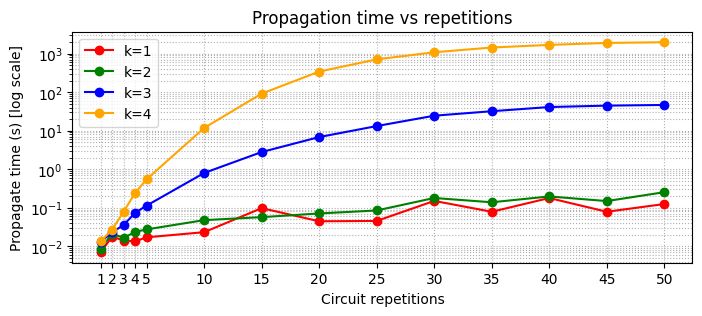

In [6]:
# Reset font size and axes linewidth to default values
plt.rcParams['font.size'] = plt.rcParamsDefault['font.size']
plt.rcParams['axes.linewidth'] = plt.rcParamsDefault['axes.linewidth']

# L_vals = [1,2,3,4,5,6] # L_vals= [1,2,3,4]
k_vals = [1, 2, 3, 4]
L_vals = [1,2,3,4,5,10,15,20,25,30,35,40,45,50]
# Prepare an empty merged dictionary with the same structure as before
prop_results_dict = {'prop_time':    {k: [] for k in k_vals},
                     'exp_time':     {k: [] for k in k_vals},
                     'expectation':  {k: [] for k in k_vals}}
colors = {1: 'red', 2: 'green', 3: 'blue', 4: 'orange'}
out_dir_kak = os.path.join("results", f"tfi")
for L in L_vals:
    filename = os.path.join(out_dir_kak, f"default_prop_results_L{L}.json")
    with open(filename, "r") as f:
        raw = json.load(f)

    # Combine the lists for each metric and k
    for metric, subdict in raw.items():
        for k in k_vals:  # Use predefined k_vals instead of iterating through dictionary keys
            k_str = str(k)
            if k_str in subdict:  # Check if this k exists in the loaded data
                v_list = subdict[k_str]
                prop_results_dict[metric][k].extend(v_list)

# Now prop_results_dict has the exact same format as before,
# with data from all L values merged together.

#  Exact truncation propagate time vs depth (Fig 2(b)), y-axis changed to log10

plt.figure(figsize=(8, 3))
for k in k_vals:
    ts = prop_results_dict['prop_time'][k]
    color = colors.get(k, 'black')  # Use black as default if k not in colors dict
    plt.plot(L_vals, ts, marker='o', label=f'k={k}', color=color)
plt.yscale('log')  # Switch to logarithmic scale (base 10)
plt.xlabel('Circuit repetitions')
plt.ylabel('Propagate time (s) [log scale]')
plt.title('Propagation time vs repetitions')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.xticks(L_vals)  # Ensure x-axis only shows integer values
plt.show()

### Monte Carlo

In [7]:
# # Define parameters
L_vals = [1,2,3,4] 
M = 10000 *20  # Number of Monte Carlo samples
nq = 127       # Number of qubits
max_kk = 6     # Maximum weight to consider

In [8]:
# WARNING: This cell runs Monte Carlo sampling, 
# results are already saved and will be loaded by subsequent cells.

# # Output directory for JSON files
# out_dir_tfi = os.path.join("results", "tfi")
# os.makedirs(out_dir_tfi, exist_ok=True)

# for L in L_vals:
#     # Build the TFI Trotter circuit & initial Pauli term 
#     qc_tfi = tfi_trotter_circuit(nqubits=127,nlayers=L,
#                                  start_with_ZZ=False,    
#                                  rzz_theta = -np.pi/2,   
#                                  rx_theta  = np.pi/3)     

#     n = qc_tfi.num_qubits

#     # Define initial Pauli operator (single Z at position 64)
#     pauli_label = "I" * 64 + "Z" + "I" * 62
#     key = encode_pauli(Pauli(pauli_label))
#     init_term = PauliTerm(1.0, key, n)
#     product_label = "0" * n
#     prop_2d = PauliPropagator(qc_tfi)

#     # Single Monte Carlo sampling run (shared across all k) 
#     mc = MonteCarlo(qc_tfi)
#     sample_file = os.path.join(out_dir_tfi, f"kicked_ising_samples_L{L}.pkl")
    
#     # Use persistent sampling - will load existing samples if available
#     _, _, last_weights, _ = mc.monte_carlo_samples(init_term=init_term, 
#                                                    M=M, 
#                                                    sample_file=sample_file,
#                                                    load_existing=True)  # Load existing samples

#     # Compute weight histogram (counts and normalized density) 
#     bins = np.arange(-0.5, n + 0.5)
#     hist_counts, bin_edges = np.histogram(last_weights, bins=bins, density=False)
#     hist_vals = hist_counts / float(len(last_weights))

#     # Estimate MC MSE for all k at once (cumulative and per‐layer) 
#     mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator=prop_2d,
#                                                          product_label=product_label)
#     cum = mse_mc_results_dict['MSE']
#     # layer = mse_mc_results_dict['layer']

#     # Package results for this L into a dictionary 
#     result_for_L = {"L": L,
#                     "weight_hist": {"hist_vals": hist_vals.tolist(),
#                                     "bin_edges": bin_edges.tolist(),
#                                     "hist_counts": hist_counts.tolist()},
#                     "MSE":     {str(k): float(cum.get(k, 0.0))   for k in range(max_kk + 1)}}
#                     # "weight_mse":  {str(k): float(layer.get(k, 0.0)) for k in range(max_kk + 1)}}

#     # Write out JSON file with L in filename 
#     filename = os.path.join(out_dir_tfi, f"tfi_mc_results_L{L}.json")
#     with open(filename, 'w') as f:
#         json.dump(result_for_L, f, indent=2, ensure_ascii=False)
#         print(f"Completed MC sampling for L={L}, results saved to: {filename}")

In [9]:
L_vals = [1,2,3,4,5,10,15,20] 

mc_results_dict =  {"MSE":     { str(k): [] for k in range(max_kk + 1)},
                    "weight_hist": {}}
# "weight_mse":  { str(k): [] for k in range(max_kk + 1) },

# For each L, open the corresponding JSON file, load the data, and append it to mc_results_dict

for L in L_vals:
    filename = os.path.join(out_dir_tfi, f"tfi_mc_results_L{L}.json")
    with open(filename, "r") as f:
        data_L = json.load(f)

    # Append single-layer ΔMSE (weight_mse) and cumulative MSE (cum_mse) to their respective lists
    for k in range(max_kk + 1):
        mc_results_dict["MSE"][str(k)].append(data_L["MSE"][str(k)])

    # Store the histogram "weight_hist" as well: directly using L's string as the key,
    # the value is still a dict containing hist_vals/list and bin_edges/list
    mc_results_dict["weight_hist"][str(L)] = data_L["weight_hist"]


<!-- # —— Single-layer ΔMSE vs weight (Fig 2c) —— 
plt.figure(figsize=(6,4))
for L in L_vals:
    kk_vals = list(range(1,5))
    ys = [mc_results_dict['weight_mse'][f"{kk}"][L_vals.index(L)] for kk in kk_vals]
    print(ys)
    plt.plot(kk_vals, ys, marker='o', label=f'L={L}')
plt.yscale('log')
plt.ylim(1e-7,5e-1)  # Set the minimum value of the y-axis to 10e-8
plt.xlabel('Weight $k$')
plt.ylabel('MC single-layer MSE $\\Delta\\mathrm{MSE}(k)$')
plt.title('Fig 2(c): layer-k MSE vs weight')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.xticks(kk_vals)  # Ensure all integers from 1 to 4 are shown on the x-axis
plt.show() -->

<!-- # —— cumulative MSE vs circuit repetitions for all kk from 0 to max_kk —— 
plt.figure(figsize=(8, 4))
for kk in range(0,5):
    ys = mc_results_dict['MSE'][f"{kk}"]   # list of length len(L_vals)
    plt.plot(L_vals, ys, marker='o', label=f'k={kk}')
plt.yscale('log')
plt.xticks(range(min(L_vals), max(L_vals)+1, 1))  # Ensure all integers from 1 to 25 are shown on the x-axis
plt.xlabel('Circuit repetitions $L$')
plt.ylabel(' $\\mathrm{MSE}^{(k)}$')
plt.title('MSE vs depth for all truncation thresholds')
plt.legend(title='Threshold $k$', ncol=2)
plt.grid(True, which='both', ls=':')
plt.show() -->


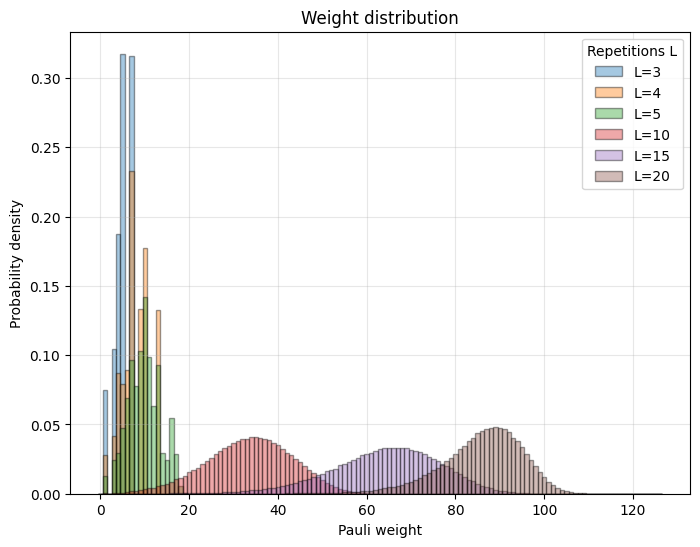

In [10]:
plt.figure(figsize=(8,6))

for L in [3,4,5,10,15,20]:
    entry     = mc_results_dict['weight_hist'][str(L)] 
    hist_vals = entry['hist_vals']    
    bin_edges = entry['bin_edges']   

    widths = [b2 - b1 for b1, b2 in zip(bin_edges[:-1], bin_edges[1:])]

    # bar chart
    plt.bar(bin_edges[:-1], hist_vals, width=widths,
            align='edge', edgecolor='black', alpha=0.4, label=f"L={L}")

plt.xlabel("Pauli weight")
plt.ylabel("Probability density")
plt.title(f"Weight distribution")
plt.legend(title="Repetitions L")
plt.grid(alpha=0.3)
plt.show()
